## Imports

In [10]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision as tv
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import os
import time 

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("device name: ", device)

from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter
from datetime import datetime

device name:  cuda:0


### Utils: Paths

In [98]:
### PATHS:
### - ./runs/:                                          Tensorboard Session Data
### -  /data2/users/lr4617/data/:                       Dataset (CIFAR10)
### - ./../../../../../data2/users/lr4617/models/:      Saved models
### - ./deltas/:                                        Adversarial Variations

## Load Data (Cifar 10)

In [4]:
partioned_dataset = input("Enter 0 for partioned dataset, any other number for standard dataset:")
## IMPORTANT: select model tag to be one of the following: CNN1, CNN2, CNN3.
model_tag = input("Enter model tag: ")

now = datetime.now()
dt_string = now.strftime("%d_%m_%Y_%H_%M_%S")
run_name = model_tag + '_' + dt_string
os.mkdir("./runs/" + run_name)

if int(partioned_dataset) == 0:
    partioned_dataset = True
    run_name = 'partioned_' + run_name

# initialize summary writer for Tensorboard
writer = SummaryWriter('./runs/' + run_name)

data_path = "/data2/users/lr4617/data/"
download_bool = False
batch_size = 64

if len(os.listdir(data_path)) == 0:
    download_bool = True

transform_data = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5), (0.5))])

cifar10_train = datasets.CIFAR10(data_path, train=True, download=download_bool, transform=transform_data)
cifar10_test = datasets.CIFAR10(data_path, train=False, download=download_bool, transform=transform_data)

train_loader = DataLoader(cifar10_train, batch_size = batch_size, shuffle=True)
test_loader = DataLoader(cifar10_test, batch_size = batch_size, shuffle=False)
# it is important NOT to shuffle the test dataset since the adversarial variation 
# delta are going to be saved in memory in the same order as the test samples are. 

# classes label for Cifar 10 dataset (just for display)
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

## Visualize Dataset

### Helper Function

In [5]:
def imshow_(img, one_channel=False):
    if one_channel:
        img = img.mean(dim=0)
    img = img / 2 + 0.5    # unnormalize
    npimg = img.numpy()
    if one_channel:
        plt.imshow(npimg, cmap="Greys")
    else:
        # plt.imshow(np.transpose((npimg* 255).astype(np.uint8), (1, 2, 0)))
        plt.imshow(np.transpose(npimg, (1, 2, 0)))

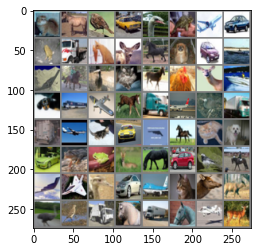

In [83]:
# dislay batch images
data_iter = iter(train_loader)
samples, labels = data_iter.next()

img = tv.utils.make_grid(samples)
imshow_(img)

## Models

In [7]:
## Simple CNN model (Standard Pytorch)
class CNN1(nn.Module):
    def __init__(self, device):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=6, kernel_size=5)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

        self.device = device

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x).to(device)

        return x

## 2 layer CNN Model
class CNN2(nn.Module):
    def __init__(self, device):

        super().__init__()
        self.device = device
        self.conv_layer = nn.Sequential(

            # Conv Layer block 1
            nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            # Conv Layer block 2
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout2d(p=0.05),
        )

        self.fc_layer = nn.Sequential(
            nn.Dropout(p=0.1),
            nn.Linear(1600, 1024),
            nn.ReLU(inplace=True),
            nn.Linear(1024, 512),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.1),
            nn.Linear(512, 10)
        )

    def forward(self, x):
        x = self.conv_layer(x)
        x = x.view(x.size(0), -1)
        x = self.fc_layer(x).to(device)
        return x

## 3-layer CNN model
class CNN3(nn.Module):
    def __init__(self, device):

        super().__init__()
        self.device = device
        self.conv_layer = nn.Sequential(

            # Conv Layer block 1
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            # Conv Layer block 2
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout2d(p=0.05),

            # Conv Layer block 3
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )

        self.fc_layer = nn.Sequential(
            nn.Dropout(p=0.1),
            nn.Linear(4096, 1024),
            nn.ReLU(inplace=True),
            nn.Linear(1024, 512),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.1),
            nn.Linear(512, 10)
        )

    def forward(self, x):
        x = self.conv_layer(x)
        x = x.view(x.size(0), -1)
        x = self.fc_layer(x).to(device)
        return x

## model selection
net = CNN1(device)


### Tensorboard Test

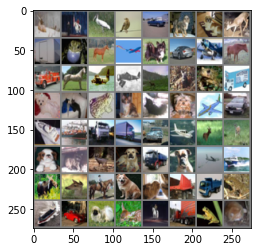

In [85]:
# get some random training images
dataiter = iter(train_loader)
images, labels = dataiter.next()

# create grid of images
img_grid = tv.utils.make_grid(images)

# show images
imshow_(img_grid, one_channel=False)

# write to tensorboard
writer.add_image('Batch Example', img_grid)
writer.add_graph(net, images)
writer.close()

## Train Model

### Utils

In [8]:
# helper functions

def images_to_probs(net, images):
    '''
    Generates predictions and corresponding probabilities from a trained
    network and a list of images
    '''
    output = net(images)
    # convert output probabilities to predicted class
    _, preds_tensor = torch.max(output, 1)
    preds = np.squeeze(preds_tensor.cpu().numpy())
    return preds, [F.softmax(el, dim=0)[i].item() for i, el in zip(preds, output)]

def plot_classes_preds(net, images, labels):
    '''
    Generates matplotlib Figure using a trained network, along with images
    and labels from a batch, that shows the network's top prediction along
    with its probability, alongside the actual label, coloring this
    information based on whether the prediction was correct or not.
    Uses the "images_to_probs" function.
    '''
    preds, probs = images_to_probs(net, images)
    # plot the images in the batch, along with predicted and true labels
    fig = plt.figure(figsize=(28*8, 28*8))
    for idx in np.arange(batch_size):
        ax = fig.add_subplot(8, 8, idx+1, xticks=[], yticks=[])
        imshow_(images.cpu()[idx], one_channel=False)
        ax.set_title("{0}, {1:.1f}%\n(label: {2})".format(
            classes[preds[idx]],
            probs[idx] * 100.0,
            classes[labels[idx]]),
                    color=("green" if preds[idx]==labels[idx].item() else "red"), fontsize=84)
    return fig

In [9]:
def train (loader, model, n_epochs=30):
    opt = optim.SGD(model.parameters(), lr=1e-1)

    for epoch_num in range(n_epochs):
        total_loss, total_err = 0.,0.
        for i, data in enumerate(loader, 0):
            X,y = data
            X,y = X.to(device), y.to(device)
            yp = model(X)
            loss = nn.CrossEntropyLoss()(yp,y)
            if opt:
                opt.zero_grad()
                loss.backward()
                opt.step()
            
            total_err += (yp.max(dim=1)[1] != y).sum().item()
            total_loss += loss.item()
            
        print(*("{:.6f}".format(i) for i in (int(epoch_num), total_err/len(loader.dataset), total_loss/len(loader.dataset))), sep="\t")   
      
        # ...log the running loss
        writer.add_scalar('training loss',
                        total_err/len(loader.dataset),
                        epoch_num* len(loader) + i)
        writer.add_scalar('training error',
                        total_loss/len(loader.dataset),
                        epoch_num* len(loader) + i)
        

In [88]:
train(train_loader, net.cuda())

0.000000	0.775880	0.032626
1.000000	0.568420	0.024594
2.000000	0.459620	0.020039
3.000000	0.377100	0.016730
4.000000	0.314900	0.014088
5.000000	0.266900	0.012018
6.000000	0.229000	0.010219
7.000000	0.196460	0.008708
8.000000	0.162260	0.007261
9.000000	0.137600	0.006059
10.000000	0.112900	0.004957
11.000000	0.094700	0.004223
12.000000	0.077080	0.003512
13.000000	0.066640	0.003014
14.000000	0.056560	0.002578
15.000000	0.048320	0.002201
16.000000	0.042740	0.001982
17.000000	0.039060	0.001800
18.000000	0.033840	0.001551
19.000000	0.032380	0.001483
20.000000	0.028580	0.001370
21.000000	0.029620	0.001341
22.000000	0.026060	0.001221
23.000000	0.022340	0.001093
24.000000	0.020740	0.001000
25.000000	0.019340	0.000949
26.000000	0.019060	0.000885
27.000000	0.019100	0.000891
28.000000	0.017320	0.000861
29.000000	0.015580	0.000760


## Save Model

In [89]:
PATH = './../../../../../data2/users/lr4617/models/' + run_name + '.pth'
dir_path = './../../../../../data2/users/lr4617/models/'
saved_models = os.listdir(dir_path)
save = True
for saved_model in saved_models:
    print(saved_model)
    if saved_model.find(run_name.split('_')[0])!= -1:
        save = False
        break
if save:
    torch.save(net, PATH)

CNN1_18_10_2021_11_40_36.pth
CNN2_18_10_2021_14_45_47.pth


## Test Model

### Utils

In [90]:
def test(model_path, test_loader, device=device):
    # net.load_state_dict(torch.load(PATH))
    net = torch.load(model_path)
    net.cuda()

    correct = 0
    total = 0

    with torch.no_grad():
        for i, data in enumerate(test_loader):
            X, y = data
            X,y = X.to(device), y.to(device)
            if i==0:
                plot_classes_preds(net, X, y)
                writer.add_figure('Predictions vs Labels',
                                plot_classes_preds(net, X, y),
                                global_step= len(test_loader) + i)
        
            outputs = net(X)
            _, predicted = torch.max(outputs.data, 1)
            total += y.size(0)
            correct += (predicted == y).sum().item()

    print('Test Accuracy: %d %%' % (100 * correct / total))

In [91]:
PATH = './../../../../../data2/users/lr4617/models/' + run_name + '.pth'
test(PATH, test_loader)

Test Accuracy: 73 %


## Adversarial Attack

### Utils

In [92]:
def fgsm(model, X, y, epsilon=0.1):
    """ Construct FGSM adversarial examples on the examples X"""
    delta = torch.zeros_like(X, requires_grad=True)
    loss = nn.CrossEntropyLoss()(model(X + delta), y)
    loss.backward()
    return epsilon * delta.grad.detach().sign()

def adversarial_test(model_path, test_loader, dir_name, device=device):
    net = (torch.load(model_path))
    net.cuda()

    correct = 0
    total = 0

    save_delta = False

    for i, data in enumerate(test_loader):
        X, y = data
        X,y = X.to(device), y.to(device)
        delta = fgsm(net, X, y)

        dir_name = './deltas/' + model_tag + '/'
        if not os.path.isdir(dir_name):
            os.mkdir(dir_name)

        if len(os.listdir(dir_name)) == 0 or save_delta==True:
            save_delta = True
            torch.save(delta, dir_name + "adversarial_delta_" + str(i) + ".pth") 
            
        outputs = net(X+delta)

        if i==0:
            plot_classes_preds(net, X+delta, y)
            writer.add_figure('Adversarial Predictions vs Labels',
                            plot_classes_preds(net, X+delta, y),
                            global_step=len(test_loader) + i)

            _, predicted = torch.max(outputs.data, 1)
            total += y.size(0)
            correct += (predicted == y).sum().item()
        
    print('ADVERSARIAL Test accuracy: %d %%' % (100 * correct / total))

### Adversarial Evaluation

In [93]:
deltas_path = './deltas/' + model_tag + '/'
PATH = './../../../../../data2/users/lr4617/models/' + run_name + '.pth'
adversarial_test(PATH, test_loader, deltas_path)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

ADVERSARIAL Test accuracy: 26 %


## Cross-Model Generalization

In [94]:
def cross_model_testing(data_path, models_path, deltas_path):

    download_bool = False
    batch_size = 64

    if len(os.listdir(data_path)) == 0:
        download_bool = True

    transform_data = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5), (0.5))])

    cifar10_test = datasets.CIFAR10(data_path, train=False, download=download_bool, transform=transform_data)
    test_loader = DataLoader(cifar10_test, batch_size=batch_size, shuffle=False)

    saved_models = os.listdir(models_path)
    deltas = os.listdir(deltas_path)

    # load desired model
    for model_path in saved_models:
        model = torch.load(models_path + model_path)
        model_name = str.split(model_path, '_')[0]

        # for the same model - test for each of the adversarial produced by all models (including model itself)
        for delta_path in deltas:
            spec_deltas = os.listdir(deltas_path + delta_path)
            delta_model_name = delta_path

            # load iterator of test image on which adversarial variation are then added
            test_iter = iter(test_loader)
            
            # load the model-specific delta and evaluate the selectd model
            correct = 0
            total = 0
            for i, model_delta in enumerate(spec_deltas):
                batch_delta = torch.load(deltas_path + delta_path + '/' + model_delta)
                X, y = test_iter.next()
                X, y = X.to(device), y.to(device)
                model.cuda()
                
                outputs = model(X+batch_delta)

                _, predicted = torch.max(outputs.data, 1)
                total += y.size(0)
                correct += (predicted == y).sum().item()
            
            print('ACCURACY ' + model_name + ' trained on ' + delta_model_name + ' ADVERSARIAL test images: %d %%' % (100 * correct / total))

In [95]:
data_path = "/data2/users/lr4617/data/"
models_path = '/data2/users/lr4617/models/'
deltas_path = './deltas/'

cross_model_testing(data_path, models_path, deltas_path)

ACCURACY CNN1 trained on CNN1 ADVERSARIAL test images: 4 %
ACCURACY CNN1 trained on CNN2 ADVERSARIAL test images: 43 %
ACCURACY CNN1 trained on CNN3 ADVERSARIAL test images: 44 %
ACCURACY CNN3 trained on CNN1 ADVERSARIAL test images: 49 %
ACCURACY CNN3 trained on CNN2 ADVERSARIAL test images: 38 %
ACCURACY CNN3 trained on CNN3 ADVERSARIAL test images: 22 %
ACCURACY CNN2 trained on CNN1 ADVERSARIAL test images: 53 %
ACCURACY CNN2 trained on CNN2 ADVERSARIAL test images: 19 %
ACCURACY CNN2 trained on CNN3 ADVERSARIAL test images: 42 %


## Cross-Training Set Generalization

In [ ]:
data_path = "/data2/users/lr4617/data/"
download_bool = False
batch_size = 64

if len(os.listdir(data_path)) == 0:
    download_bool = True

transform_data = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5), (0.5))])


cifar10_train = datasets.CIFAR10(data_path, train=True, download=download_bool, transform=transform_data)
cifar10_test = datasets.CIFAR10(data_path, train=False, download=download_bool, transform=transform_data)

test_loader = DataLoader(cifar10_test, batch_size = batch_size, shuffle=False)

models_path = '/data2/users/lr4617/models/'
num_of_partitions = len(os.listdir(models_path))

for i in range(3):
    cifar10_train_partitioned = cifar10_train[i*len(cifar10_train): (i+1)*len(cifar10_train), :]
    train_loader = DataLoader(cifar10_train_partitioned, batch_size = batch_size, shuffle=True)



## Partition Dataset in 3

## Train each model on a different dataset partition

## Test each model on the entire test dataset

## Evaluate Adversarial Robustness for each of the model

## 

## Select models that have been trained on disjoint dataset among the saved models 